<a href="https://colab.research.google.com/github/yardsale8/probability_simulations_in_R/blob/main/3_1_2_generating_independent_random_variates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)
library(devtools)
install_github('yardsale8/purrrfect', force = TRUE)
library(purrrfect)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: usethis





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpHLaBo2/remotes58887c7384d1/yardsale8-purrrfect-b314b85/DESCRIPTION’ ... OK
* preparing ‘purrrfect’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘purrrfect_1.2.5.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘purrrfect’


The following objects are masked from ‘package:base’:

    replicate, tabulate




# Generating Independent Random Variates

In this notebook, we will demonstrate methods for simulating independent random variates, including

1. Generating IID random variates using the base R functions, and
2. Generating bivariate independent random variates using `replicate2`.

## Generating IID Random Variates

The easiest way to generate independent and identically distributed random variates is using the base R functions for the given parameter distribution.  For example, to generates 100 experiments, each with 10 IID random variables that are $norm(2,3)$, we would simply use

```
replicate(100, rnorm(10, 2, 3))
```

### Example 1 - A IID sample from the Poisson distribution.

Calls coming into a call center can be modelled as a Poisson point process with a mean rate of 10 calls per minute.  Let $X_i$ represent the number of calls received in the $i^{th}$ minutes, for $i=1,...,5$ and $Y = \sum_{i=1}^{5} X_i$ the total calls in the last 5 minutes.

**Questions.**

1. Plot the estimated PMF of $Y$,
2. Estimate the $P(Y > 45)$, and
3. Esimate the mean and variance of $Y$.

#### Step 1 - Generate 60 independent draws from $Poisson(10)$ and compute $Y$.

In [2]:
num_trials <- 10
n <- 5
el <- 10
( replicate(num_trials, rpois(n, el),
            .as = Xs)
  %>% mutate(Y = map_int(Xs, sum))
)

.trial,Xs,Y
<dbl>,<list>,<int>
1,"8, 10, 11, 13, 7",49
2,"8, 11, 12, 5, 12",48
3,"10, 6, 14, 14, 10",54
4,"11, 7, 15, 9, 11",53
5,"12, 10, 13, 9, 4",48
6,"7, 7, 12, 11, 6",43
7,"8, 9, 10, 10, 9",46
8,"8, 12, 9, 10, 13",52
9,"8, 7, 8, 12, 13",48


#### Bump number of trials and save.

In [3]:
num_trials <- 10000
n <- 5
el <- 10
( replicate(num_trials, rpois(n, el),
            .as = Xs)
  %>% mutate(Y = map_int(Xs, sum))
) -> five_minutes_of_calls

five_minutes_of_calls %>% head

.trial,Xs,Y
<dbl>,<list>,<int>
1,"9, 7, 15, 9, 8",48
2,"10, 16, 9, 12, 15",62
3,"7, 5, 7, 10, 14",43
4,"10, 7, 18, 12, 13",60
5,"9, 12, 12, 17, 8",58
6,"8, 11, 12, 17, 16",64


#### Step 3 - Plot the estimated PMF of $Y$

Warning message:
“`stat(density)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


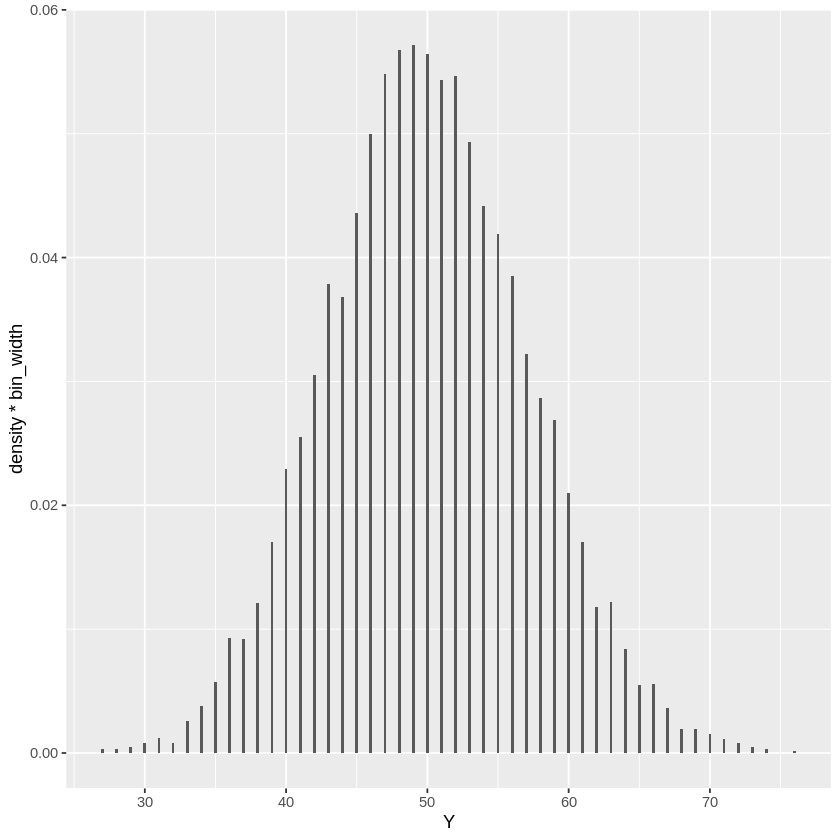

In [4]:
bin_width = 0.2
ggplot(data = five_minutes_of_calls,  aes(x = Y)) +
  geom_histogram(aes(y = stat(density) * bin_width), binwidth = bin_width)

#### Step 4 - Estimate the probability

In [5]:
(five_minutes_of_calls
 %>% mutate(greater_than_45 = Y > 45)
 %>% estimate_all_prob
 )

greater_than_45
<dbl>
0.7392


#### Step 5 - Estimate the mean and variance

In [6]:
(five_minutes_of_calls
 %>% summarise(mu = mean(Y), var = var(Y))
)

mu,var
<dbl>,<dbl>
50.0475,49.95344


## Generating the bivariate distribution of two independent random variables

Suppose that $X_1$ and $X_2$ are independent random variables from two different distributions.  We can simulate this scenario using the `replicate2` function, which is used to replicate two random expressions, one for each variable.  For example, we could use the following to generate 100 independent binomial and Poisson trials.

```
replicate2_int(100, rbinom(1, 10, 0.5), rpois(1, 10))
```
As with `replicate`, we assigned the output type of `int` to both variable.



### Example 2 - Waiting on calls.

We return the the previous scenario, where calls coming into a call center can be modelled as a Poisson point process with a mean rate of 10 calls per minute. Let  $X_1$  represent the time until the 10th call, and let $X_2$ be the subsequent time until we get 20 more calls.  

**Questions.**

1. Find $P(2*X_1 <= X_2)$, and
2. Show the $Y = \frac{X_1}{X_1 + X_2}\sim beta(10, 20)$ by comparing CDFs.

#### Step 1 -- Generate $X_1$ and $X_2$

In [7]:
num_trials <- 10000
a1 <- 10
a2 <- 20
el <- 10
(replicate2_dbl(num_trials, rgamma(1, a1, el), rgamma(1, a2, el),
                             .as1 = x1, .as2 = x2)
) -> wait_times

wait_times %>% head

.trial,x1,x2
<dbl>,<dbl>,<dbl>
1,1.1279962,1.757736
2,0.9754141,2.650908
3,1.1096852,2.236744
4,1.0831112,1.901587
5,0.4994296,1.413889
6,0.9397242,2.521971


#### Step 2 -  Estimate $P(2*X_1 <= X_2)$

In [8]:
(wait_times
 %>% mutate(twice_x1_less_equal_x2 = 2*x1 <= x2)
 %>% estimate_all_prob
 )


twice_x1_less_equal_x2
<dbl>
0.5146


#### Step 3 - Estimate the covariance and correlation.


In [9]:
(wait_times
 %>% mutate(Y = x1/(x1 + x2))
 %>% mutate(eCDF = cume_dist(Y),
            tCDF = map_dbl(Y, \(y) pbeta(y, 10, 20)))
 ) -> ratio_of_wait_times

 ratio_of_wait_times %>% head

.trial,x1,x2,Y,eCDF,tCDF
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.1279962,1.757736,0.3908873,0.7570,0.7549560
2,0.9754141,2.650908,0.2689816,0.2318,0.2335446
3,1.1096852,2.236744,0.3316028,0.5055,0.5092967
4,1.0831112,1.901587,0.3628880,0.6453,0.6476749
5,0.4994296,1.413889,0.2610279,0.2006,0.2039761
6,0.9397242,2.521971,0.2714636,0.2418,0.2431512


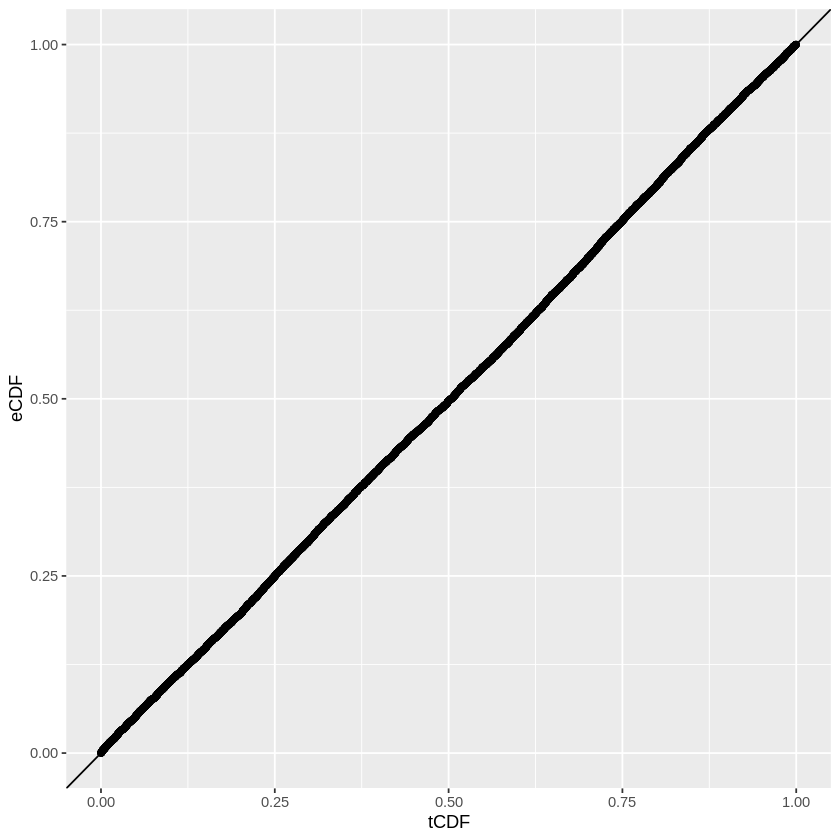

In [10]:
ggplot(data = ratio_of_wait_times) +
  geom_abline(aes(slope = 1, intercept = 0)) +
  geom_point(aes(x = tCDF, y = eCDF))

## Generating bivariate data using the marginal + conditional distributions.

The most general approach to generating bivariate data is to

1. Generate one random variable from its marginal distribution, then
2. Generate the other from the conditional distribution using the value from $1.$

### Example 3 - Random draws from an urn

Suppose that we have an urn with 10 blue and 15 white chips.  Our experiment is to first roll a fair 6-sided die, then draw that many chips from the urn.  Let $X$ be the roll of the die and $Y$ be the number of blue chips drawn in the $X=x$ total chips on that draw.

**Questions.**

1. Estimate the probability of at least one blue chip, and
2. Estimate the mean and variance of $Y$.

In [17]:
num_trials <- 100000
die <- 1:6
urn <- c(rep(1, 10), rep(0, 15)) # Use 1/0 to easily compute the number of blue chips.
(replicate_int(num_trials, sample(die, 1), .as = roll)
 %>% mutate(chips = map(roll, \(r) sample(urn, r)),
            y = map_int(chips, sum))
) -> chips

chips %>% head

.trial,roll,chips,y
<dbl>,<int>,<list>,<int>
1,5,"1, 1, 0, 1, 0",3
2,3,"0, 1, 1",2
3,4,"1, 0, 0, 1",2
4,4,"1, 0, 0, 1",2
5,3,"0, 0, 0",0
6,4,"1, 1, 0, 0",2


#### Problem 1 - Probability of at least one blue

In [18]:
(chips
 %>% mutate(at_least_one = y >= 1)
 %>% estimate_all_prob
)

at_least_one
<dbl>
0.77814


#### Problem 2 - Estimate the mean and variance

In [19]:
(chips
 %>% summarise(mu_y = mean(y),var_y = var(y))
)

mu_y,var_y
<dbl>,<dbl>
1.40471,1.187632


### Example 4 - Simulating flaws.

Suppose that the rate of flaws will vary over batches of materials, while this rate remains relatively constant within a batch.  Let $R$ represent the rate of flaws in a randomly selected batch, with $R\sim norm(10, 0.5)$, and let $X_1, ..., X_10$ represent the number of flaws in a batch of 10 items with a rate of $R = r$ flaws per item.  Assume that the $X$s are IID $pois(r)$.

**Question.** Find the probability that the minimum number of flaws in a randomly selected batch is less than 5.

In [24]:
num_trials <- 10000
(replicate_dbl(num_trials, rnorm(1, 10, 0.5), .as = R)
 %>% mutate(Xs = map(R, \(r) rpois(10, r)),
            minX = map_int(Xs, min))
) -> batches

batches %>% head

.trial,R,Xs,minX
<dbl>,<dbl>,<list>,<int>
1,9.571535,"16, 9, 9, 12, 8, 12, 10, 14, 14, 8",8
2,10.174325,"11, 7, 16, 14, 10, 8, 8, 10, 8, 14",7
3,9.839420,"14, 8, 14, 10, 14, 10, 13, 7, 14, 12",7
4,9.872171,"9, 6, 6, 6, 8, 11, 8, 11, 10, 8",6
5,10.118354,"8, 7, 10, 8, 10, 9, 9, 7, 7, 10",7
6,10.322107,"13, 10, 8, 7, 12, 16, 14, 12, 10, 15",7


In [25]:
(batches
 %>% mutate(less_than_5 = minX < 5)
 %>% estimate_all_prob
)


less_than_5
<dbl>
0.2633
